## Springboard Capstone 03 - Food Allergens

### 04 Modeling

### 1.0 Set up and import statements

### 1.1 Mount Google Drive and check

In [36]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#verify directories
!ls '/content/gdrive/My Drive/Springboard/Capstone_Three/data/foodallergens'

 00105.jpg		  images   startendimageids.csv        'Untitled document.gdoc'
 foodallergenlabels.csv   output   start_end_img_check.gsheet


In [3]:
#provide data directory
DATA_DIR = "/content/gdrive/My Drive/Springboard/Capstone_Three/data/foodallergens/"

### 1.2 Import packages

In [4]:
#Import statements
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint


### 1.3 Import Labels

In [5]:
#Import label data
df = pd.read_csv(DATA_DIR + 'foodallergenlabels.csv')

In [6]:
df.rename(columns={'Unnamed: 0': 'food'}, inplace=True)
df.head()

,food,labels,milk,eggs,fish,shellfish,tree nuts,peanuts,wheat,soybeans,sesame,id
0,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00001.jpg
1,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00041.jpg
2,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00042.jpg
3,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00043.jpg
4,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00044.jpg


### 1.4 Set up images and output directories

In [7]:
IMG_DIR = DATA_DIR + 'images/'

In [9]:
#output folder
OUT_DIR = "/content/gdrive/My Drive/Springboard/Capstone_Three/data/foodallergens/output/"

## 2.0 EDA

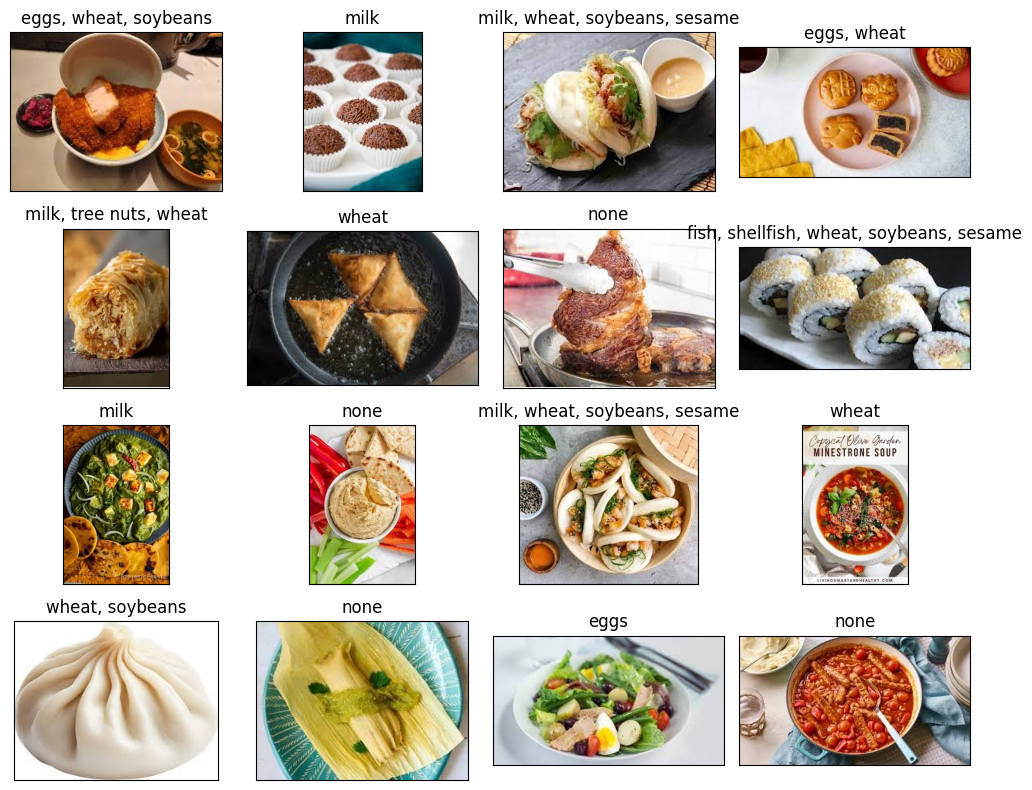

In [10]:
#Plot a sample of images w/ labels

num_images = 16

#get a sample of images from labels file (which contains the image file name under 'id')
df_sampled = df.sample(n=num_images)

#get labels for samples
labels = df_sampled['labels'].values

#get image info for samples
ids = df_sampled['id'].values

#retrieve those ids from the images folder
image_data = []
for j in range(len(ids)):
  path = IMG_DIR + ids[j]
  img = plt.imread(path)
  image_data.append(img)

#print(image_data[1])

fig, axes = plt.subplots(4, 4, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(image_data[i])  # Display the image
            ax.set_title(labels[i])  # Set the label as title
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks
        else:
            ax.axis('off') # Turn off empty subplots
plt.tight_layout()
plt.savefig(OUT_DIR + 'image_samples.png')
plt.show()

# get a random image to load

#img = load_img(IMG_DIR + '07279.jpg')
#img = load_img(DATA_DIR + '00105.jpg')
# find more about the image
# print(type(img))
# print(img.format)
# print(img.mode)
# print(img.size)

# show the image
#plt.imshow(image_data[3])

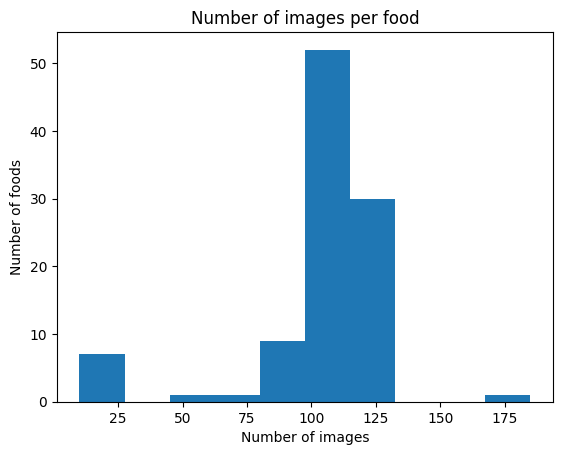

In [11]:
#Can you create a histogram that shows the distribution of each allergy in the dataset?
#df_temp = df.groupby('food').size().sort_values(ascending=False).head(20)

plt.hist(df.groupby('food').size())
plt.title('Number of images per food')
plt.xlabel('Number of images')
plt.ylabel('Number of foods')
plt.savefig(OUT_DIR + 'num_images_per_food.png')
plt.show()

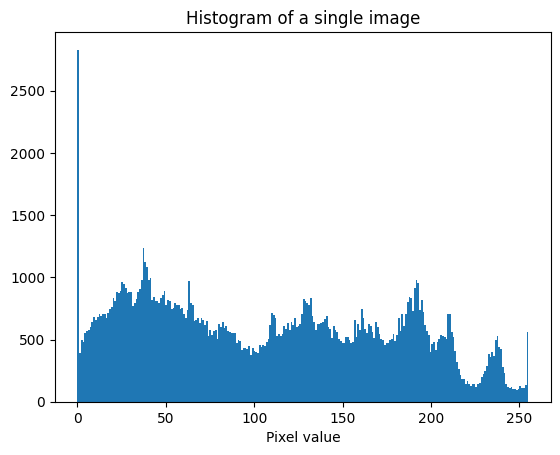

In [12]:
#Histogram of a single image
plt.hist(image_data[0].flatten(), bins=256)
plt.title('Histogram of a single image')
plt.xlabel('Pixel value')
plt.savefig(OUT_DIR + 'histogram_single_image.png')
plt.show()

## 3.0 Prepare Data

In [13]:
#Import images, format as array and normalize (maybe before shuffling?)
#What does a (2000, 200, 200, 3) array look like?

!pip install pillow
from PIL import UnidentifiedImageError # import the error explicitly

size = 200
X_data = []
for i in tqdm(range(df.shape[0])):
  try:
    img = image.load_img(IMG_DIR + df['id'][i], target_size=(size, size, 3))
    img = image.img_to_array(img)
    img = img/255
    X_data.append(img)
  except UnidentifiedImageError:
    print(f"Could not open image: {IMG_DIR + df['id'][i]}")
    continue
X_arr = np.array(X_data)


 10%|▉         | 999/10484 [03:30<39:19,  4.02it/s]

Could not open image: /content/gdrive/My Drive/Springboard/Capstone_Three/data/foodallergens/images/00984.jpg


100%|██████████| 10484/10484 [36:20<00:00,  4.81it/s]


In [14]:
df.shape

(10484, 12)

In [15]:
X_arr.shape

(10483, 200, 200, 3)

In [16]:
df.head()

,food,labels,milk,eggs,fish,shellfish,tree nuts,peanuts,wheat,soybeans,sesame,id
0,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00001.jpg
1,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00041.jpg
2,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00042.jpg
3,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00043.jpg
4,adobo,"wheat, soybeans",0,0,0,0,0,0,1,1,0,00044.jpg


In [17]:
#Format y data
#Remove corrupted image
df_temp = df[df['id'] != '00984.jpg']
y_arr = np.array(df_temp.drop(['food', 'labels', 'id'], axis=1))
y_arr.shape

(10483, 9)

In [19]:
#Shuffle the data

X, y = shuffle(X_arr, y_arr)

[1 0 0 0 0 0 0 0 0]


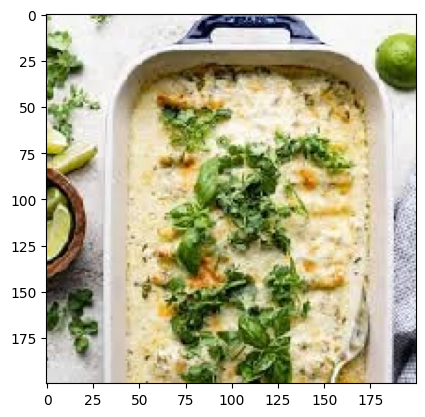

In [20]:
#Check that images and labels match

imno = 495
print(y[imno])
plt.imshow(X[imno])
plt.show()

In [21]:
#Split the data into train, validate, test
#Manually separate out a certain amount for the test data: X_test and y_test
#Use train_test_split to create train and validate sets: X_train, X_val, y_train, y_val
# X = X[:9435]
# test_X = X[9435:]
# y = y[:9435]
# test_y = X[9435:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.01)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

## 4.0 Create and test models

### 4.1 Create first CNN model

In [22]:
#Create model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5),activation='relu',input_shape=(size,size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
model.add(Dropout(0.2))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 196, 196, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 196, 196, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 98, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 98, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 43, 43, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 17, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 305,257 (1.16 MB)

 Trainable params: 304,777 (1.16 MB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
#Compile model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Fit first model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.1847 - loss: 1.0881 - val_accuracy: 0.1175 - val_loss: 0.4710
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.1840 - loss: 1.0643 - val_accuracy: 0.1151 - val_loss: 0.4853
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1880 - loss: 1.0693 - val_accuracy: 0.1276 - val_loss: 0.4730
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1884 - loss: 1.0824 - val_accuracy: 0.2659 - val_loss: 0.5065
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2021 - loss: 1.0575 - val_accuracy: 0.1474 - val_loss: 0.4654
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.2014 - loss: 1.0492 - val_accuracy: 0.1989 - val_loss: 0.4876
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.1917 - loss: 1.0862 - val_accuracy: 0.1671 - val_loss: 0.4774
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.2024 - loss: 1.0381 - val_acc

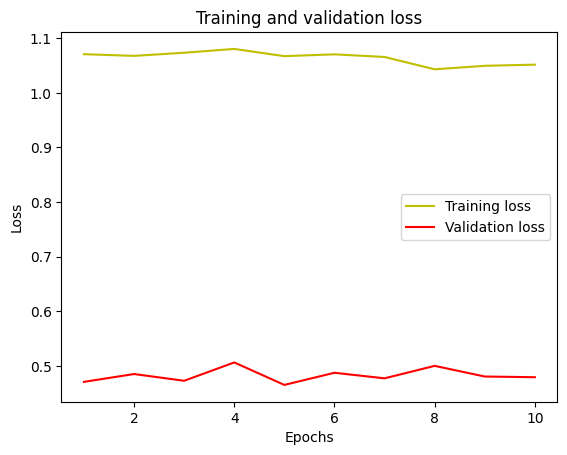

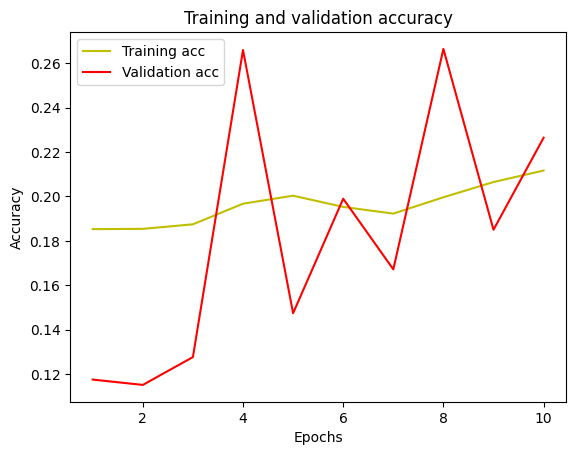

In [ ]:
#Plot metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(OUT_DIR + "train_val_loss_01C.png")
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(OUT_DIR + "train_val_acc_01C.png")
plt.show()

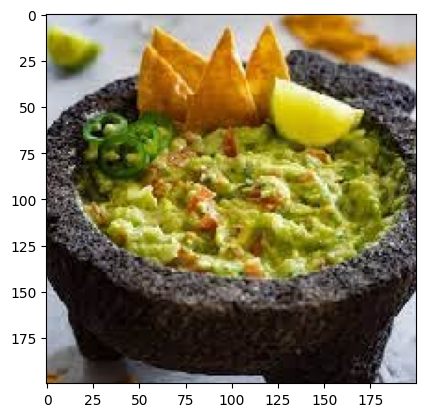

[0 0 0 0 0 0 0 0 0]


In [32]:
#Check on an image from the test set
testimg = X_test[0]
plt.imshow(testimg)
plt.show()

X_test[0].shape #-> (200, 200, 3)

#Have to add term to beginning of image
testimg = np.expand_dims(testimg, axis=0)
testimg.shape #-> (1, 200, 200, 3)

testlabel = y_test[0]
print(testlabel)

In [34]:
classes = np.array(df.columns[2:11])
print(classes)

['milk' 'eggs' 'fish' 'shellfish' 'tree nuts' 'peanuts' 'wheat' 'soybeans'
 'sesame']


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2418 - loss: 0.5040
Test Loss: 0.5001741051673889
Test Accuracy: 0.24761904776096344


### 4.1.1 Predict on an image from the test set

In [ ]:
probs = model.predict(testimg)
sorted_categories = np.argsort(probs[0])[:-10:-1]
print(sorted_categories)

for i in range(9):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(probs[0][sorted_categories[i]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0 6 1 4 5 8 7 2 3]
milk (0.655)
wheat (0.6)
eggs (0.462)
tree nuts (0.258)
peanuts (0.159)
sesame (0.0415)
soybeans (0.0325)
fish (0.00591)
shellfish (0.00348)


### 4.2 CNN model with callbacks

In [ ]:
#Instantiate callbacks
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)
model_checkpoint = ModelCheckpoint('best_foodallergen_model.keras', save_best_only = True)

In [ ]:
#Modified fitting with callbacks
history = model.fit(X_train, y_train, epochs=1000000, callbacks=[monitor_val_acc, model_checkpoint], validation_data=(X_val, y_val), batch_size=64)

Epoch 1/1000000
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.2268 - loss: 1.0438 - val_accuracy: 0.2437 - val_loss: 0.4532
Epoch 2/1000000
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.2396 - loss: 1.0492 - val_accuracy: 0.2452 - val_loss: 0.4570
Epoch 3/1000000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2507 - loss: 1.0182 - val_accuracy: 0.2144 - val_loss: 0.4558
Epoch 4/1000000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2652 - loss: 1.0353 - val_accuracy: 0.1797 - val_loss: 0.4620
Epoch 5/1000000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2499 - loss: 1.0387 - val_accuracy: 0.1633 - val_loss: 0.4619


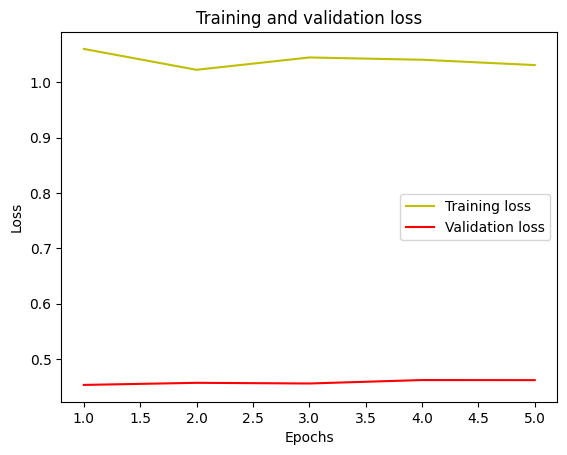

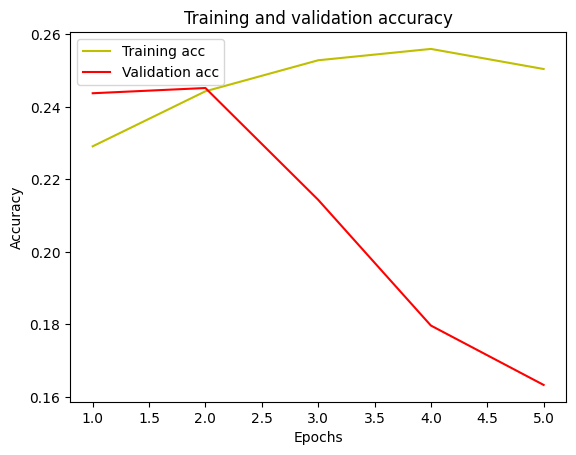

In [ ]:
#Plot metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(OUT_DIR + "train_val_loss_02C.png")
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(OUT_DIR + "train_val_acc_02C.png")
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1738 - loss: 0.4637
Test Loss: 0.4616752862930298
Test Accuracy: 0.17142857611179352


In [ ]:
probs = model.predict(testimg)
sorted_categories = np.argsort(probs[0])[:-10:-1]
print(sorted_categories)

for i in range(9):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(probs[0][sorted_categories[i]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[6 0 1 5 8 7 4 2 3]
wheat (0.527)
milk (0.334)
eggs (0.32)
peanuts (0.224)
sesame (0.14)
soybeans (0.126)
tree nuts (0.106)
fish (0.075)
shellfish (0.0628)


### 4.3 Hyperparameter tuning #1

In [ ]:
#Hyperparameter tuning
#activation functions for Conv2D layers, epochs, batch size, (number of samples?), number of hidden layers?
#from DC: number of layers, number of neurons per layer, layer order, layer activations, batch sizes, learning rates, optimizers


In [24]:
!pip install scikeras

In [25]:
#New import statments
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#HPTuning for optimizer, batch size and activation (hidden layers)

np.random.seed(42)

def create_model(optimizer='adam', activation='relu', epochs=6, batch_size=32):
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=(5, 5),activation=activation,input_shape=(size,size,3)))
  model.add(Conv2D(filters=32, kernel_size=(5, 5),activation=activation))
  model.add(Flatten())
  model.add(Dense(9, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss='binary_crossentropy')
  return model

#don't need a lot of epochs
model = KerasClassifier(build_fn=create_model)

kfold = cross_val_score(model, X_train, y_train, cv=3)

#mean accuracy per fold
kfmean = kfold.mean()

#standard deviation per fold
kfstd = kfold.std()

#params = dict(optimizer=['sgd', 'adam'], epochs=[3, 100, 200], batch_size=[16, 32, 64], activation=['relu', 'tanh'])
params = dict(model__optimizer=['sgd', 'adam'], # Change to model__optimizer
              model__epochs=[3, 100, 200], # Change to model__epochs
              model__batch_size=[16, 32, 64], # Change to model__batch_size
              model__activation=['relu', 'tanh']) # Change to model__activation
random_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=3)
random_search_results = random_search.fit(X_train, y_train)

print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 1.4065
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 1.5898
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 1.9305
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 6.0969
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 5.4269
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 6.9920
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 1.3002
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 1.6638
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 1.1265
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 86.5690
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.5749
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 78.8303
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 74.9467
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.5623
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 82.7940
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.5196
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.5011
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5035
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 6.1483
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 5.5025
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 10.1223
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 6.7733
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 5.5833
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 6.7574
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5313
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5027
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5137
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5311
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5017
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5464
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 1.9273
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 1.1952
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.7207
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 1.0164
Best: 0.188630 using {'model__optimizer': 'adam', 'model__epochs': 200, 'model__batch_size': 64, 'model__activation': 'relu'}


### 4.4 Hyperparameter tuning #2

In [23]:
#HP Tuning for number of layers and number of neurons (or in this case # of filters)
#Could also look at tuning for kernel size, stride and padding

np.random.seed(42)

def create_model_2(nl=1, filt=64):
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu',input_shape=(size,size,3)))
  for i in range(nl):
    model.add(Conv2D(filters=filt, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(9, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

#don't need a lot of epochs
model = KerasClassifier(build_fn=create_model_2, epochs=6, batch_size=32)

kfold = cross_val_score(model, X_train, y_train, cv=3)

#mean accuracy per fold
kfmean = kfold.mean()

#standard deviation per fold
kfstd = kfold.std()

#not sure why epochs does not need to be specified here
params = dict(model__nl=[1, 2, 4, 8], model__filt=[16, 32, 64, 128])
random_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=3)
random_search_results = random_search.fit(X_train, y_train)

print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - loss: 1.1559
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.4812
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.4398
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.3303
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.1984
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.1300
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - loss: 1.3288
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.4742
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.3883
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.2536
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.1517
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0889
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 1.8504
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.4427
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.2520
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0962
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0381
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0262
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.6608
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.4729
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.4209
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.2732
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1518
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0865
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.8815
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.4806
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.4480
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.3607
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.2205
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1304
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.8480
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.4702
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.4035
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.2981
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1982
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1330
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 1.3903
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.9411
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.7814
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.5467
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.4196
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.3364
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 1.4512
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.9258
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.7345
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.5398
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.3977
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.2988
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 1.4490
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.9061
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.6724
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.5057
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.3908
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.2870
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 2.5058
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.5163
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.0758
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.6937
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.4531
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.3482
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 2.6805
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.7040
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.2545
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.8571
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.5686
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.3537
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 2.4204
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.6167
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.1322
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.6643
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.4265
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.2999
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 86s 356ms/step - loss: 0.7368
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - loss: 0.6124
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - loss: 0.5892
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - loss: 0.5497
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - loss: 0.5284
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5023
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 68s 355ms/step - loss: 0.7456
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.6016
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - loss: 0.5795
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5403
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5144
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - loss: 0.4932
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - loss: 0.7153
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - loss: 0.6249
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5892
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5757
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5360
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - loss: 0.5083
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 227ms/step - loss: 9.1731
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - loss: 6.2683
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - loss: 3.9698
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - loss: 1.5404
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - loss: 0.7500
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - loss: 0.3749
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 228ms/step - loss: 8.8403
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - loss: 6.0548
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - loss: 4.4155
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - loss: 2.6211
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - loss: 1.2994
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - loss: 0.6396
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - loss: 9.1305
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - loss: 6.2133
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - loss: 3.4336
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - loss: 1.6100
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - loss: 0.6759
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - loss: 0.3688
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 1.5109
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.4886
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.4445
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.3093
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.1606
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0834
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 1.2604
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.4882
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.4494
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.3074
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.1416
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0596
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 1.8505
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.4761
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.3880
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.2042
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0864
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0489
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - loss: 4.5346
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 2.4272
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 1.2932
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - loss: 0.6335
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - loss: 0.3581
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 0.2249
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - loss: 4.5506
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - loss: 2.9243
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 2.4428
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 1.6936
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 0.9571
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 0.5457
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - loss: 4.3376
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - loss: 2.8781
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 1.9133
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 1.0917
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 0.5568
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 0.3057
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.6745
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5216
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5042
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4933
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4783
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4787
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.6687
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.5263
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.5048
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4957
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4779
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4727
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - loss: 0.6813
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.5321
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.5112
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.5002
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4801
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.4746
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Epoch 1/6
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - loss: 0.6347
Epoch 2/6
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.5135
Epoch 3/6
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.4885
Epoch 4/6
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.4771
Epoch 5/6
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.4662
Epoch 6/6
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.4635
Best: 0.145027 using {'model__nl': 4, 'model__filt': 16}


### 5.0 Creation of final model

In [26]:
#Final model

#Create model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5),activation='relu',input_shape=(size,size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(5, 5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
model.add(Dropout(0.2))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 196, 196, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 196, 196, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 98, 98, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 98, 98, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 94, 94, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 47, 47, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 47, 47, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 43, 43, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 21, 21, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 21, 21, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 21, 21, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 17, 17, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 16)            │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 2, 16)            │              64 │
│ (BatchNormalization)                 │                             │              

 Total params: 31,945 (124.79 KB)

 Trainable params: 31,785 (124.16 KB)

 Non-trainable params: 160 (640.00 B)

In [27]:
#Compile model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
#Fit first model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.1416 - loss: 2.5982 - val_accuracy: 0.0983 - val_loss: 0.5191
Epoch 2/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.1490 - loss: 1.3419 - val_accuracy: 0.0983 - val_loss: 0.4893
Epoch 3/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1572 - loss: 1.2064 - val_accuracy: 0.0983 - val_loss: 0.4856
Epoch 4/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.1791 - loss: 1.1491 - val_accuracy: 0.1113 - val_loss: 0.4858
Epoch 5/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1864 - loss: 1.1328 - val_accuracy: 0.1108 - val_loss: 0.4814
Epoch 6/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1808 - loss: 1.1281 - val_accuracy: 0.1055 - val_loss: 0.4794
Epoch 7/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.1812 - loss: 1.1266 - val_accuracy: 0.1060 - val_loss: 0.4792
Epoch 8/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1803 - loss: 1.1176 

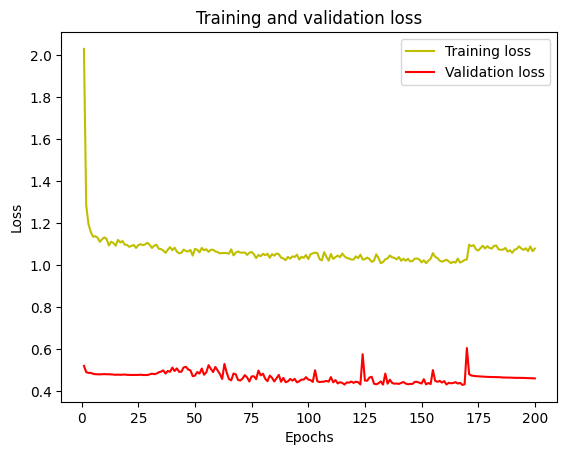

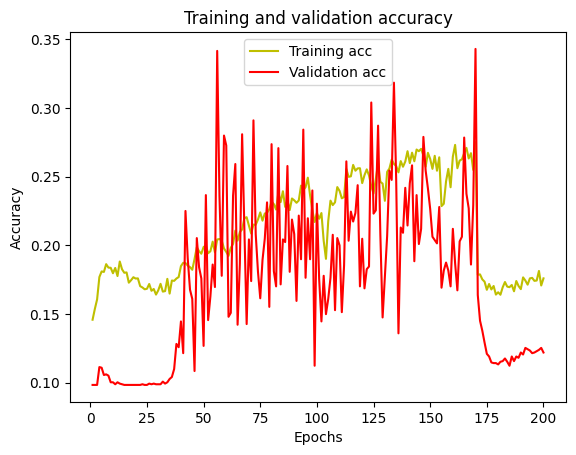

In [29]:
#Plot metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(OUT_DIR + "train_val_loss_final.png")
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(OUT_DIR + "train_val_acc_final.png")
plt.show()

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.1429 - loss: 0.4425
Test Loss: 0.4444774389266968
Test Accuracy: 0.190476194024086


In [35]:
probs = model.predict(testimg)
sorted_categories = np.argsort(probs[0])[:-10:-1]
print(sorted_categories)

for i in range(9):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(probs[0][sorted_categories[i]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[3 6 2 0 1 8 4 7 5]
shellfish (0.231)
wheat (0.23)
fish (0.19)
milk (0.19)
eggs (0.162)
sesame (0.103)
tree nuts (0.0879)
soybeans (0.0666)
peanuts (0.0481)
